In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits
from algorithms import *
plt.rcParams['figure.figsize'] = [8, 6]

In [2]:
filename = 'YearPredictionMSD.txt'
data = np.loadtxt(filename, delimiter=',', skiprows=1)
y = data[:,0]
y = y.reshape((len(y), 1))
X = data[:,1:]

In [3]:
def Linear_Regression_SGD(x, y, eta, K, L=0, q=None):
    #Initialize weights and bias
    b = 0
    w = np.zeros([x.shape[1],1])
    
    costs = []
    norm = []
    y = y.reshape((len(y),1))
    
    #For each iteration
    for k in tqdm(range(K), disable=tqdmSwitch):
        
        #Draw random sample with replacement
        idx = np.random.randint(0,len(y))
        xx = x[idx]
        yy = y[idx]
        
        #Fixed learning rate
        a = eta
        #a = eta/np.sqrt(k+1)
        
        #Make prediction
        y_pred = xx@w

        #Update weights
        grad = (xx*(y_pred-yy)).reshape((x.shape[1],1))
        w = w - a*(grad + L*w)

        #Compute cost
        pred = x@w
        #norm += [np.linalg.norm(grad)]
        costs += [mean_squared_error(y, pred, squared=False)/x.shape[0]]
        
    if q != None:
        q.put([w, b, np.array(costs)])
        
    return w, b, np.array(costs)

def Linear_Regression_SAG(x, y, eta, K, L=0, q=None):
    #Initialize weights and bias
    b = 0
    w = np.zeros([x.shape[1],1])
    g = np.zeros((x.shape[0], x.shape[1],1)) #Gradient table
    G = np.zeros_like(w) #Gradient table sum
    idxs = []
    m = 0
    
    costs = []
    norm = []
    y = y.reshape((len(y),1))
    
    #For each iteration
    for k in tqdm(range(K), disable=tqdmSwitch):
        
        #Draw random sample with replacement
        idx = np.random.randint(0,len(y))
        xx = x[idx]
        yy = y[idx]
        
        #Fixed learning rate
        a = eta
        
        #Make prediction
        y_pred = xx@w

        #Check if data point has been seen
        if idx not in idxs:
            idxs += [idx]
            m += 1
        
        #Calculate current gradient
        grad = (xx*(y_pred-yy)).reshape((x.shape[1],1))
        #Update gradient table
        G = G - g[idx] + grad
        #Update previous sample gradient
        g[idx] = grad
        #Update weights
        w = w - a*(G/m + L*w)

        #Compute cost
        pred = x@w
        costs += [mean_squared_error(y, pred, squared=False)/x.shape[0]]
        
    if q != None:
        q.put([w, b, np.array(costs)])
        
    return w, b, np.array(costs)

def Linear_Regression_SAGA(x, y, eta, K, L=0, q=None):
    #Initialize weights and bias
    b = 0
    w = np.zeros([x.shape[1],1])
    g = np.zeros((x.shape[0], x.shape[1],1)) #Gradient table
    G = np.zeros_like(w) #Gradient table sum
    idxs = []
    m = 0
    
    costs = []
    norm = []
    y = y.reshape((len(y),1))
    
    #For each iteration
    for k in tqdm(range(K), disable=tqdmSwitch):
        
        #Draw random sample with replacement
        idx = np.random.randint(0,len(y))
        xx = x[idx]
        yy = y[idx]
        
        #Fixed learning rate
        a = eta
        
        #Make prediction
        y_pred = xx@w

        #Check if data point has been seen
        if idx not in idxs:
            idxs += [idx]
            m += 1
        
         #Calculate current gradient
        grad = (xx*(y_pred-yy)).reshape((x.shape[1],1))
        #Update weights
        w = w - a*((grad - g[idx] + G/m) + L*w)
        #Update gradient table
        G = G - g[idx] + grad
        #Update previous sample gradient
        g[idx] = grad

        #Compute cost
        pred = x@w
        costs += [mean_squared_error(y, pred, squared=False)/x.shape[0]]
        
    if q != None:
        q.put([w, b, np.array(costs)])
        
    return w, b, np.array(costs)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, shuffle=False)

In [6]:
w1, _, costs1 = Linear_Regression_SGD(X_train, y_train, 1e-10, 100000)
w2, _, costs2 = Linear_Regression_SAG(X_train, y_train, 1e-10, 100000)
w3, _, costs3 = Linear_Regression_SAGA(X_train, y_train, 1e-10, 100000)

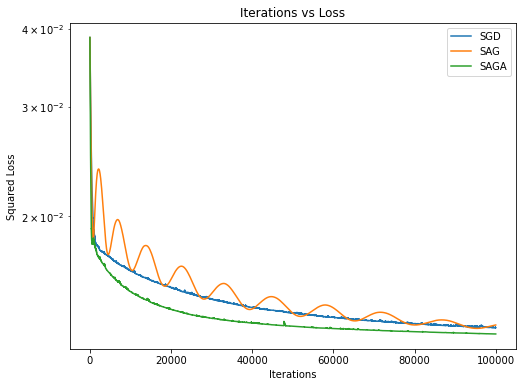

In [7]:
plt.plot(np.arange(len(costs1)), costs1, label="SGD")
plt.plot(np.arange(len(costs2)), costs2, label="SAG")
plt.plot(np.arange(len(costs3)), costs3, label="SAGA")
plt.xlabel("Iterations")
plt.ylabel("Squared Loss")
plt.title("Iterations vs Loss")
plt.legend()
plt.yscale("log")